In [60]:
import os, re, time, sys
import pandas as pd
import numpy as np
from  geopy.geocoders import Nominatim
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
def text2int(textnum, numwords={}):
    if not numwords:
      units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
      ]

      tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

      scales = ["hundred", "thousand", "million", "billion", "trillion"]

      numwords["and"] = (1, 0)
      for idx, word in enumerate(units):    numwords[word] = (1, idx)
      for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
      for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            break
#           raise Exception("Illegal word: " + word)
            

        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [3]:
def locFromText(text):
    tofilter = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen","strike","strikes","near","destroyed","the","engaged"
      ]
    t = re.search(r'Near (.*?)(?:[,;]|(?!.*\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b)){1,3}', text)
    if t:
        red=' '.join(t.group(1).split()[:5])
        red = red.replace('and','|')
        red = red.replace('-',' ')
        red = red.replace('ar','al')
        red = red.lower()
        if len(red) < 2:
            return None
        else:
            return " ".join([w for w in red.split() if not w in tofilter])
    else:
        return None

## Import the previously parsed data

In [4]:
df = pd.read_feather('allreports.feather')
df.shape

(9723, 4)

In [5]:
df["loc"] = df.apply(lambda x: locFromText(x.text), axis=1)
# print(df["loc"].unique())

In [6]:
# Get Number of Strikes
df["strikes"] = df.apply(lambda x: x["text"].split(' strike',1)[0].split(', ')[-1],axis=1)
df["strikes"] = df.apply(lambda x: x.strikes if x.strikes.isnumeric() else text2int(x.strikes), axis=1)

## Location Lookup Table

In [7]:
locdf=pd.DataFrame(df["loc"].unique(),columns=["city"])

In [8]:
locdf.fillna(value=pd.np.nan, inplace=True)
locdf.dropna(inplace=True)
locdf.head(10)

,city
0,al shadaddi
1,ar raqqah
2,tabqah
3,al qaim
4,haditha
5,mosul
6,tal afal
7,dayr az zawr
9,huwijah
10,rawah


In [9]:
def g(t):
    l=geolocator.geocode(t,timeout = 10)
    if l:
        return [l.longitude, l.latitude]
    else:
        pd.np.nan

geolocator = Nominatim()
geolocator.country_bias = "SY"
locdf["location"] = locdf.apply(lambda x: g(x["city"]), axis=1 )
locdf

/Users/andrewlb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


,city,location
0,al shadaddi,None
1,ar raqqah,"[39.0089212, 35.949678]"
2,tabqah,"[38.5414697, 35.8323648]"
3,al qaim,None
4,haditha,None
...,...,...
159,shadaddi,None
160,dayr az,"[40.1499999, 35.3333335]"
161,tal abayad,None
162,dayr palymyra,None


In [10]:
df["coords"] = df.apply(lambda x: locdf.loc[locdf['city'] == x["loc"],["location"]], axis=1)

In [11]:
df.head()

,index,report,text,filename,loc,strikes,coords
0,1,20170406-01," Near Al Shadaddi, one strike engaged an ISIS...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al shadaddi,1,location 0 None
1,3,20170406-01," Near Ar Raqqah, two strikes destroyed an ISI...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,ar raqqah,2,"location 1 [39.0089212, 35...."
2,5,20170406-01," Near Tabqah, 13 strikes engaged nine ISIS ta...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,tabqah,13,"location 2 [38.5414697, 35..."
3,7,20170406-01," Near Al Qaim, one strike destroyed two anti-...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,al qaim,1,location 3 None
4,9,20170406-01," Near Haditha, one strike engaged an ISIS tac...",20170406%20Strike%20Release.pdf?ver=2017-04-06...,haditha,1,location 4 None


## Getting Datetime set up

In [ ]:
# Fix to one of the report IDs
# On second thought, this is a bad idea, because I want to assoc with report ID, even if they are incorrect
# df.at[142,"report"] = "20160528-1"
# df.at[143,"report"] = "20160528-1"
# df.at[144,"report"] = "20160528-1"
# df.at[145,"report"] = "20160528-1"
# df.at[146,"report"] = "20160528-1"
# df.at[147,"report"] = "20160528-1"
# df.at[148,"report"] = "20160528-1"
# df.at[149,"report"] = "20160528-1"
# df.at[150,"report"] = "20160528-1"
# df.at[151,"report"] = "20160528-1"
# df.at[152,"report"] = "20160528-1"
# df.at[153,"report"] = "20160528-1"
# df.at[154,"report"] = "20160528-1"
# df.at[155,"report"] = "20160528-1"
# df.at[156,"report"] = "20160528-1"

In [12]:
# Convert the initial dates as referenced in reports
df["report_date"] = df.apply(lambda x : pd.to_datetime( x["report"].split("-")[0], errors="coerce",yearfirst=True),axis=1)

In [13]:
nulldates = pd.isnull(df["report_date"]).nonzero()

/Users/andrewlb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  """Entry point for launching an IPython kernel.


In [14]:
date_pattern = re.compile("([0-9]{4}\-[0-9]{2}\-[0-9]{2})")

def extract_date(filename):
    matches = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", filename)
    if matches:
        return parse(matches.group(0))
    else:
        return None
    
print(df.loc[539,"report"])
print(df.loc[539,"filename"].replace("%20"," "))
print(extract_date(df.loc[539,"filename"].replace("%20"," ")))
#parse( ,fuzzy_with_tokens=True)

2015011
11 Jan Strike Release.pdf?ver=2017-01-13-131050-560.pdf
1310-01-13 00:00:00


In [15]:
unmatched = pd.DataFrame(df.loc[nulldates]["filename"].unique(),columns=["filename"])
unmatched["date"] = np.nan

In [16]:
unmatched.at[0,"date"] = "20160528"
unmatched.at[1,"date"] = "20150125"
unmatched.at[2,"date"] = "20150111"
unmatched.at[3,"date"] = "20150426"
unmatched.at[4,"date"] = "20151013"
unmatched.at[5,"date"] = "20151018"
unmatched.at[6,"date"] = "20160526"
unmatched.at[7,"date"] = "20151010"
unmatched.at[8,"date"] = "20151017"
unmatched.at[9,"date"] = "20150107"
unmatched.at[10,"date"] = "20150419"
unmatched.at[11,"date"] = "20150103"
unmatched.at[12,"date"] = "20150105"
unmatched.at[13,"date"] = "20150201"
unmatched.at[14,"date"] = "20160531"
unmatched.at[15,"date"] = "20160525"
unmatched.at[16,"date"] = "20150123"
unmatched.at[17,"date"] = "20160521"
unmatched.at[18,"date"] = "20150106"
unmatched.at[19,"date"] = "20181128"
unmatched.at[20,"date"] = "20170129"
unmatched.at[21,"date"] = "20150110"
unmatched.at[22,"date"] = "20150104"
unmatched.at[23,"date"] = "20150126"
unmatched.at[24,"date"] = "20151019"
unmatched.at[25,"date"] = "20150415"
unmatched.at[26,"date"] = "20150426"
unmatched.at[27,"date"] = "20151015"
unmatched.at[28,"date"] = "20151012"
unmatched.at[29,"date"] = "20150213"
unmatched.at[30,"date"] = "20150112"
unmatched.at[31,"date"] = "20150522"
unmatched.at[32,"date"] = "20161122"
unmatched.at[33,"date"] = "20150108"
unmatched.at[34,"date"] = "20150115"
unmatched.at[35,"date"] = "20160522"
unmatched.at[36,"date"] = "20150118"
unmatched.at[37,"date"] = "20150101"
unmatched.at[38,"date"] = "20161121"
unmatched.at[39,"date"] = "20150114"
unmatched.at[40,"date"] = "20160520"
unmatched.at[41,"date"] = "20170121"
unmatched.at[42,"date"] = "20150431"
unmatched.at[43,"date"] = "20160524"
unmatched.at[44,"date"] = "20150116"
unmatched.at[45,"date"] = "20150122"
unmatched.at[46,"date"] = "20151016"
unmatched.at[47,"date"] = "20151011"
unmatched.at[48,"date"] = "20160523"
unmatched.at[49,"date"] = "20160529"
unmatched.at[50,"date"] = "20160530"
unmatched.at[51,"date"] = "20150109"
unmatched.at[52,"date"] = "20150113"
unmatched.at[53,"date"] = "20150503"
unmatched.at[54,"date"] = "20150119"
unmatched.at[55,"date"] = "20150124"
unmatched.at[56,"date"] = "20151014"
unmatched.at[57,"date"] = "20150120"
unmatched.at[58,"date"] = "20150121"
unmatched.at[59,"date"] = "20150117"
unmatched.at[60,"date"] = "20150413"
unmatched.at[61,"date"] = "20160527"
unmatched.at[62,"date"] = "20181121"
unmatched.at[63,"date"] = "20150102"
unmatched.at[64,"date"] = "20170122"

In [17]:
unmatched['datetime'] = pd.to_datetime(unmatched['date'].astype(str).apply(lambda x:x.split(".")[0]),
                                       yearfirst=True, 
                                       format="%Y%m%d",
                                       exact=False,
                                       errors='coerce')

In [ ]:
# unmatched.to_feather("broken-dates.feather") #Just a quick backup...

In [18]:
df.dtypes

index                   int64
report                 object
text                   object
filename               object
loc                    object
strikes                object
coords                 object
report_date    datetime64[ns]
dtype: object

In [19]:
unmatched.dtypes

filename            object
date               float64
datetime    datetime64[ns]
dtype: object

In [49]:
df["report_date"] = df.apply(lambda x: 
                            next(iter(unmatched.loc[unmatched['filename'] == x["filename"]]["datetime"]))
                             if pd.isnull(x["report_date"])
                             else x["report_date"],
                             axis=1)
                                  




In [50]:
df.dtypes

index                   int64
report                 object
text                   object
filename               object
loc                    object
strikes                object
coords                 object
report_date    datetime64[ns]
dtype: object

## Extract Specific Strikes

In [117]:
df.loc[0].text
# Continued this on 04

'\uf0b7 Near Al Shadaddi, one strike engaged an ISIS tactical unit and destroyed a fighting '

## Plot Initial Values

In [ ]:
df['AGE'].plot.hist(title='Proportion of owner-occupied units built prior to 1940', colormap='jet')
plt.xlabel('AGE')
plt.ylabel('FREQUENCY')

In [ ]:

df["strikes"] = pd.to_numeric(df["strikes"])

In [ ]:
df.set_index("report_date")

In [ ]:
df["report_date"].reset_index().astype('datetime64')


In [79]:
# df.dtypes
# df["report"] = df["report"].astype(str)
# df["text"] = df["report"].astype(str)
# df["filename"] = df["report"].astype(str)
# df["loc"] = df["report"].astype(str)
df["strikes"] = pd.to_numeric(df["strikes"])
# df["report_date_new"] = df["report_date"].reset_index()

In [83]:
df.groupby(pd.Grouper(key='report_date', freq='M')).strikes.mean()

report_date
2015-01-31     1.293333
2015-02-28     0.793427
2015-03-31     1.011050
2015-04-30     0.690678
2015-05-31     0.531381
2015-06-30     0.680556
2015-07-31     1.556196
2015-08-31     1.824513
2015-09-30     1.527778
2015-10-31     1.983819
2015-11-30     2.531148
2015-12-31     2.436667
2016-01-31     2.376997
2016-02-29     2.191919
2016-03-31     1.970395
2016-04-30     2.117284
2016-05-31     1.940171
2016-06-30     2.751572
2016-07-31     2.340067
2016-08-31     1.960854
2016-09-30     1.993464
2016-10-31     1.959732
2016-11-30     2.612245
2016-12-31     2.344828
2017-01-31     3.400000
2017-02-28     3.544248
2017-03-31     3.416667
2017-04-30     3.408696
2017-05-31     3.096154
2017-06-30     4.294393
2017-07-31     3.610577
2017-08-31     4.357143
2017-09-30     6.357143
2017-10-31     3.573099
2017-11-30     2.250000
2017-12-31     3.423729
2018-01-31     6.595238
2018-02-28     3.952381
2018-03-31     1.467742
2018-04-30     1.681818
2018-05-31     3.240000
2018

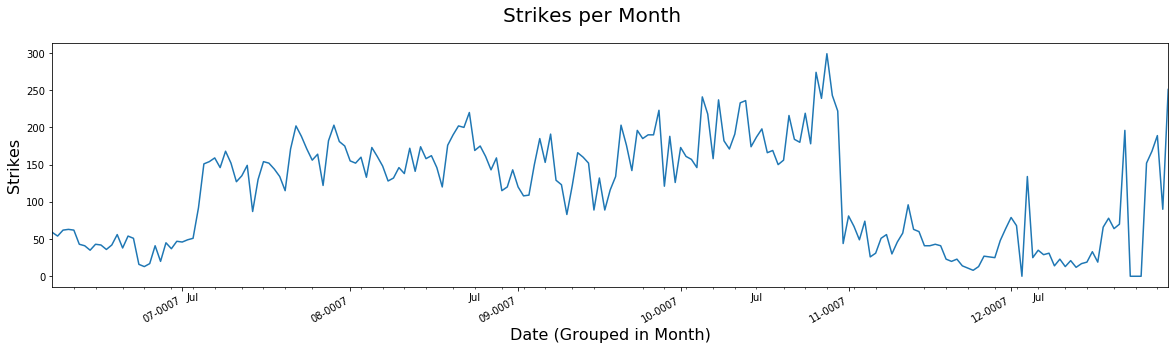

In [110]:
# Strikes per Month

ax = df.groupby(pd.Grouper(key='report_date', freq='W')).strikes.sum().plot(figsize=[20,5])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.suptitle('Strikes per Month',fontsize=20)
plt.xlabel("Date (Grouped in Month)",fontsize=16)
plt.ylabel("Strikes",fontsize=16)
plt.gcf().autofmt_xdate()
plt.show()

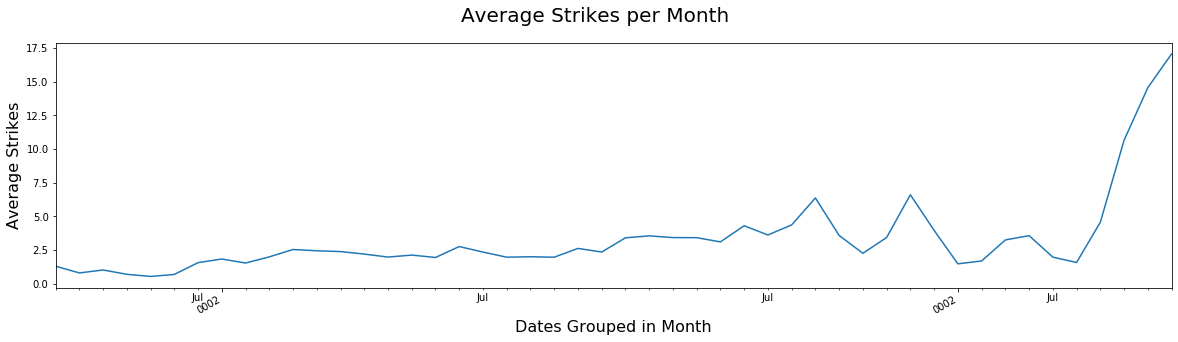

In [98]:
# Average Strikes per month

ax = df.groupby(pd.Grouper(key='report_date', freq='M')).strikes.mean().plot(figsize=[20,5])
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.suptitle('Average Strikes per Month',fontsize=20)
plt.xlabel("Dates Grouped in Month",fontsize=16)
plt.ylabel("Average Strikes",fontsize=16)
plt.gcf().autofmt_xdate()
plt.show()

#df.sort_values('report_date', ascending=True).plot(x="report_date",y="strikes",figsize=[20,5],type="scatter")

In [59]:
df.groupby(pd.Grouper(key='report_date', freq='M')).describe()


index                                                    
             count       mean        std  min   25%   50%    75%   max
report_date                                                           
NaT          225.0   6.764444   4.195297  1.0  3.00   6.0  10.00  18.0
2015-01-31   213.0   6.568075   4.016630  1.0  3.00   6.0  10.00  20.0
2015-02-28   181.0   5.889503   3.687660  1.0  3.00   6.0   8.00  17.0
2015-03-31   236.0   6.915254   4.164850  1.0  3.00   7.0  10.00  19.0
2015-04-30   239.0   7.723849   4.606250  1.0  4.00   7.0  11.00  20.0
2015-05-31   288.0   8.048611   4.670808  1.0  4.00   8.0  12.00  19.0
2015-06-30   347.0   9.838617   5.751844  1.0  5.00  10.0  14.00  25.0
2015-07-31   359.0  10.083565   6.066552  1.0  5.00  10.0  15.00  27.0
2015-08-31   360.0  10.116667   6.262392  1.0  5.00  10.0  15.00  29.0
2015-09-30   309.0   8.957929   5.946311  1.0  4.00   8.0  13.00  29.0
2015-10-31   305.0   9.327869   5.810385  1.0  5.00   9.0  13.00  31.0
2015-11-30   300.0   8.536667   5.527250  1.0  4.00   8.0  12.00  21.0
2015-12-31   313.0   8.738019   5.517024  1.0  4.00   8.0  13.00  24.0
2016-01-31   297.0   8.680135   5.213876  1.0  4.00   8.0  13.00  23.0
2016-02-29   304.0   8.546053   5.415829  1.0  4.00   8.0  12.00  24.0
2016-03-31   324.0   9.030864   5.573514  1.0  4.00   9.0  13.00  23.0
2016-04-30   351.0   9.173789   5.639757  1.0  4.00   9.0  13.50  22.0
2016-05-31   318.0   9.311321   5.729491  1.0  5.00   9.0  13.75  25.0
2016-06-30   297.0   7.720539   4.703293  1.0  4.00   8.0  11.00  19.0
2016-07-31   281.0   7.309609   4.629897  0.0  3.00   7.0  11.00  20.0
2016-08-31   306.0   8.150327   4.920711  1.0  4.00   8.0  12.00  21.0
2016-09-30   298.0   7.630872   4.871202  1.0  4.00   7.0  11.00  23.0
2016-10-31   245.0   6.661224   4.039194  1.0  3.00   6.0  10.00  17.0
2016-11-30   203.0   5.615764   3.666837  1.0  3.00   5.0   8.00  17.0
2016-12-31   230.0   6.600000   4.259692  1.0  3.00   6.0   9.75  19.0
2017-01-31   226.0   8.097345   5.214449  1.0  3.25   7.0  11.00  25.0
2017-02-28   204.0   6.715686   4.413096  1.0  3.00   6.0   9.00  19.0
2017-03-31   230.0   6.326087   4.350648  0.0  3.00   6.0  10.00  19.0
2017-04-30   260.0   7.565385   4.821881  0.0  3.00   7.0  11.00  21.0
2017-05-31   214.0   6.738318   4.612366  1.0  3.00   6.0   9.75  22.0
2017-06-30   208.0   5.937500   3.591581  1.0  3.00   6.0   9.00  15.0
2017-07-31   196.0   5.132653   3.123567  1.0  2.00   5.0   7.25  13.0
2017-08-31   168.0   6.297619   4.846827  1.0  3.00   5.0   8.00  21.0
2017-09-30   171.0   6.473684   4.438224  1.0  3.00   6.0   9.00  20.0
2017-10-31    92.0   9.021739   6.526326  1.0  4.00   7.5  13.00  26.0
2017-11-30    59.0   8.440678   6.366050  1.0  3.00   7.0  11.00  27.0
2017-12-31    42.0  10.523810   6.149512  1.0  5.00  11.0  15.00  21.0
2018-01-31    42.0  10.761905   6.734728  1.0  5.00  10.5  15.00  26.0
2018-02-28    62.0  11.725806   7.017938  1.0  6.00  11.5  17.00  27.0
2018-03-31    44.0  11.590909   7.851287  1.0  5.00  11.0  15.50  30.0
2018-04-30    75.0  12.186667   8.414423  1.0  5.00  11.0  18.00  31.0
2018-05-31    66.0  16.030303  10.081162  1.0  8.00  16.0  23.00  41.0
2018-06-30    56.0  12.732143   9.106423  1.0  5.00  11.0  18.50  33.0
2018-07-31    44.0  10.454545   6.289358  1.0  5.00  10.0  16.00  21.0
2018-08-31    43.0  10.581395   6.325431  1.0  5.00  11.0  15.50  22.0
2018-09-30    31.0   9.645161   6.843724  0.0  4.00   9.0  14.00  25.0
2018-10-31    35.0  12.800000   8.550198  1.0  6.00  11.0  18.50  31.0
2018-11-30    20.0   9.750000   5.683540  1.0  5.00   9.5  14.25  19.0
2018-12-31   213.0   6.568075   4.016630  1.0  3.00   6.0  10.00  20.0

In [ ]:
df[df["filename"]=="CJTF-OIR%20Strike%20Release%20201808013-02.pdf?ver=2018-08-13-093333-010.pdf"]

In [123]:
del df["coords"]
df.reset_index().to_feather("03-post.feather")